In [47]:
import warnings
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

warnings.filterwarnings("ignore")

#import sklearn
#sklearn.show_versions()
#sklearn.__version__
set_config(display='diagram')

In [48]:
import ray
import flaml

ray.__version__
flaml.__version__

'0.10.0'

In [49]:
data = pd.read_csv('data/train.csv', index_col=0)

In [50]:
from sklearn.preprocessing import MinMaxScaler
from numpy import log
from datetime import date, datetime

def feature_generation(data):

    # this is needed for the later part of the feature generation
    if 'congestion' not in data:
        data['congestion'] = np.nan
    
    data.time = pd.to_datetime(data.time)

    # data.loc[:, 'hour'] = data.time.dt.hour
    # data.loc[:, 'minute'] = data.time.dt.minute
    # data.loc[:, 'month'] = data.time.dt.month
    # data.loc[:, 'day'] = data.time.dt.day
    # data.loc[:, 'day_of_week'] = data.time.dt.dayofweek
    data.loc[:, 'is_weekend'] = data.time.dt.dayofweek >= 5

    start_date = pd.to_datetime(date(1991, 4, 1)) #where the dataset beggins
    data.loc[:, 'days_since_beg_of_time'] = [(a_date - start_date).days for a_date in data.time]

    n_minutes_1_day = 24*60
    data.loc[:, 'sin_time'] = np.sin(2*np.pi*(data.time.dt.hour * 60 + data.time.dt.minute)/n_minutes_1_day)
    data.loc[:, 'cos_time'] = np.cos(2*np.pi*(data.time.dt.hour * 60 + data.time.dt.minute)/n_minutes_1_day)

    data.loc[:, 'x_y'] = data['x'].astype(str) + "_" + data['y'].astype(str)
    data.loc[:, 'road_id'] = data['x'].astype(str) + data['y'].astype(str) + data['direction']
    
    congestion_wide = data.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
    for shift in [1, 2, 3, 72, 504]: # lags: t-1, t-2, t-3, t=72 => 1 day, t=504 =>1 week
        shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
        shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
        data = data.merge(shifted_data, on = ['time', 'road_id'])
        
    features = data.columns
    return data, features

# scaler = MinMaxScaler()
data, features = feature_generation(data)

#data[features] = scaler.fit_transform(data[features])

data

,time,x,y,direction,congestion,is_weekend,days_since_beg_of_time,sin_time,cos_time,x_y,road_id,congestion_t1,congestion_t2,congestion_t3,congestion_t72,congestion_t504
0,1991-04-01 00:00:00,0,0,EB,70,False,0,0.000000,1.000000,0_0,00EB,NaN,NaN,NaN,NaN,NaN
1,1991-04-01 00:00:00,0,0,NB,49,False,0,0.000000,1.000000,0_0,00NB,NaN,NaN,NaN,NaN,NaN
2,1991-04-01 00:00:00,0,0,SB,24,False,0,0.000000,1.000000,0_0,00SB,NaN,NaN,NaN,NaN,NaN
3,1991-04-01 00:00:00,0,1,EB,18,False,0,0.000000,1.000000,0_1,01EB,NaN,NaN,NaN,NaN,NaN
4,1991-04-01 00:00:00,0,1,NB,60,False,0,0.000000,1.000000,0_1,01NB,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54,False,182,0.087156,-0.996195,2_3,23NB,59.0,58.0,52.0,54.0,50.0
848831,1991-09-30 11:40:00,2,3,NE,28,False,182,0.087156,-0.996195,2_3,23NE,22.0,29.0,25.0,20.0,24.0
848832,1991-09-30 11:40:00,2,3,SB,68,False,182,0.087156,-0.996195,2_3,23SB,69.0,69.0,70.0,68.0,69.0
848833,1991-09-30 11:40:00,2,3,SW,17,False,182,0.087156,-0.996195,2_3,23SW,22.0,19.0,20.0,12.0,21.0


In [38]:
# ?? pd.DataFrame.plot

In [55]:
means = data.groupby(pd.Grouper(key='time', freq='1D')).congestion.mean().to_frame()

<AxesSubplot:xlabel='time'>

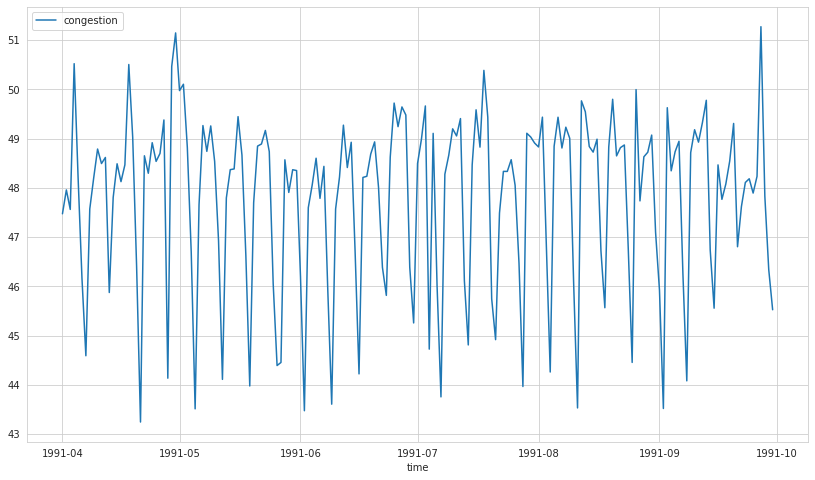

In [80]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(14, 8))
#plt.plot(means)

import seaborn as sns
sns.set_style("whitegrid")
sns.lineplot(data=means)

In [117]:
#means.loc['1991-05-30']
means['is_weekend'] = pd.to_datetime(means.index).dayofweek >= 5

In [119]:
means[(means.index >= '1991-04-20') & (means.index <= '1991-05-10')]

#May 5-Cinco de Mayo

,congestion,is_weekend
time,,
1991-04-20,46.409534,True
1991-04-21,43.243590,True
1991-04-22,48.649145,False
1991-04-23,48.294444,False
1991-04-24,48.914556,False
1991-04-25,48.535470,False
1991-04-26,48.697222,False
1991-04-27,49.376282,True
1991-04-28,44.133547,True


In [120]:
means[(means.index >= '1991-07-1') & (means.index <= '1991-07-14')]

,congestion,is_weekend
time,,
1991-07-01,48.492308,False
1991-07-02,48.988034,False
1991-07-03,49.660684,False
1991-07-04,44.723718,False
1991-07-05,49.104274,False
1991-07-06,46.014744,True
1991-07-07,43.754274,True
1991-07-08,48.274573,False
1991-07-09,48.660684,False


In [108]:
pd.to_datetime(data.index)

DatetimeIndex([          '1970-01-01 00:00:00',
               '1970-01-01 00:00:00.000000001',
               '1970-01-01 00:00:00.000000002',
               '1970-01-01 00:00:00.000000003',
               '1970-01-01 00:00:00.000000004',
               '1970-01-01 00:00:00.000000005',
               '1970-01-01 00:00:00.000000006',
               '1970-01-01 00:00:00.000000007',
               '1970-01-01 00:00:00.000000008',
               '1970-01-01 00:00:00.000000009',
               ...
               '1970-01-01 00:00:00.000848825',
               '1970-01-01 00:00:00.000848826',
               '1970-01-01 00:00:00.000848827',
               '1970-01-01 00:00:00.000848828',
               '1970-01-01 00:00:00.000848829',
               '1970-01-01 00:00:00.000848830',
               '1970-01-01 00:00:00.000848831',
               '1970-01-01 00:00:00.000848832',
               '1970-01-01 00:00:00.000848833',
               '1970-01-01 00:00:00.000848834'],
              dtype=

In [ ]:
to-do:
    
- dropar fins de semana
- trocar o 4 de julho com uma 5ª feira anterior ou seguinte
- ajustar a periodicidade na feature generation
- retreinar